
# TO COMPLETE

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
file_path = '../airflow/data/production/flights.csv'
df = pd.read_csv(file_path)
df.head()

,id,scheduled_time,departure_icao,arrival_icao,delay_in_minutes,flight_status,airline,flight_number,departure_wind,departure_visibility,departure_sky_condition,departure_temperature,departure_altimeter,destination_wind,destination_visibility,destination_sky_condition,destination_temperature,destination_altimeter
0,76,2025-01-08T06:00:00.000,kmco,kfll,17,active,spirit airlines,195,34010KT,10SM,CLR,07/00,3025.0,31008KT,10SM,FEW030,12/07,3016.0
1,78,2025-01-08T09:35:00.000,kmco,kfll,0,active,azul,6953,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0
2,80,2025-01-08T09:35:00.000,kmco,kfll,0,active,jetblue airways,5453,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0
3,82,2025-01-08T09:35:00.000,kmco,kfll,0,active,copa airlines,5053,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0
4,84,2025-01-08T09:35:00.000,kmco,kfll,0,active,united airlines,3053,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         151 non-null    int64  
 1   scheduled_time             151 non-null    object 
 2   departure_icao             151 non-null    object 
 3   arrival_icao               151 non-null    object 
 4   delay_in_minutes           151 non-null    int64  
 5   flight_status              151 non-null    object 
 6   airline                    151 non-null    object 
 7   flight_number              151 non-null    int64  
 8   departure_wind             151 non-null    object 
 9   departure_visibility       151 non-null    object 
 10  departure_sky_condition    151 non-null    object 
 11  departure_temperature      151 non-null    object 
 12  departure_altimeter        150 non-null    float64
 13  destination_wind           151 non-null    object 

C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_17572\558016399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_delays.index, y=airline_delays.values, palette='viridis')


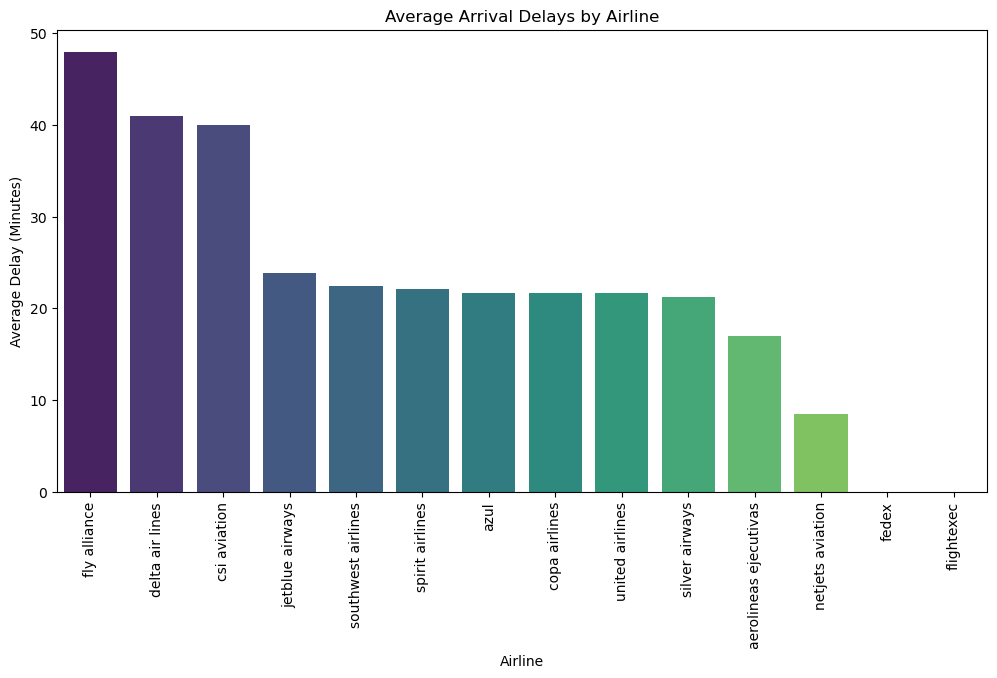

In [78]:
# Group by airline and calculate mean delays
airline_delays = df.groupby('airline')['delay_in_minutes'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delays.index, y=airline_delays.values, palette='viridis')
plt.title('Average Arrival Delays by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=90)
plt.show()

In [79]:
import re

# Function to determine if the wind is strong (e.g., > 30 knots)
def is_strong_wind(wind):
    match = re.search(r'(\d{2})', wind)  # Find the first two digits (wind speed in knots)
    if match:
        wind_speed = int(match.group(1))
        return wind_speed > 30
    return False

# Function to check visibility (e.g., < 3 statute miles)
def is_low_visibility(visibility):
    if 'SM' in visibility:
        visibility_value = float(visibility.replace('SM', ''))
        return visibility_value < 3
    return False

# Function to check if sky condition is bad (BKN, OVC, TCU, CB)
def is_bad_sky_condition(sky_condition):
    if any(condition in sky_condition for condition in ['BKN', 'OVC', 'TCU', 'CB']):
        return True
    return False


# Function to check if the temperature is extreme (e.g., below -5°C or above 40°C)
def is_extreme_temperature(temperature):
    match = re.match(r'(\d+)', temperature.split('/')[0])  # Extract temperature from format like "07/02"
    if match:
        temp = int(match.group(1))
        return temp < -5 or temp > 40
    return False

# Now we apply these functions to create a 'BadWeatherDeparture' column
def determine_bad_weather_departure(weather_row):
    wind, visibility, sky_condition, temperature = weather_row
    if (is_strong_wind(wind) or 
        is_low_visibility(visibility) or 
        is_bad_sky_condition(sky_condition) or 
        is_extreme_temperature(temperature)):
        return 1  # Bad weather
    return 0  # Good weather


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_17572\1194231609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BadWeatherDeparture', y='delay_in_minutes', data=df_departure, palette='coolwarm')


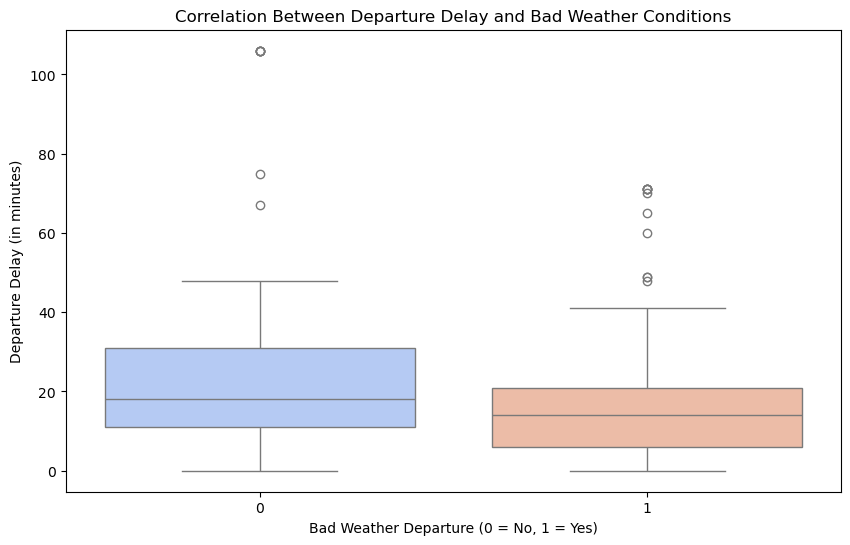

In [80]:
df_departure = df

# Apply the function to the 'WeatherDeparture' column
df_departure['BadWeatherDeparture'] = df_departure[['departure_wind', 'departure_visibility', 'departure_sky_condition', 'departure_temperature']].apply(determine_bad_weather_departure, axis=1)

df_departure = df_departure.dropna(subset=['delay_in_minutes', 'BadWeatherDeparture'])

# Create a scatter plot to show the correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='BadWeatherDeparture', y='delay_in_minutes', data=df_departure, palette='coolwarm')

# Set plot title and labels
plt.title('Correlation Between Departure Delay and Bad Weather Conditions')
plt.xlabel('Bad Weather Departure (0 = No, 1 = Yes)')
plt.ylabel('Departure Delay (in minutes)')

# Show plot
plt.show()

C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_17572\3011454321.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BadWeatherDestination', y='delay_in_minutes', data=df_destination, palette='coolwarm')


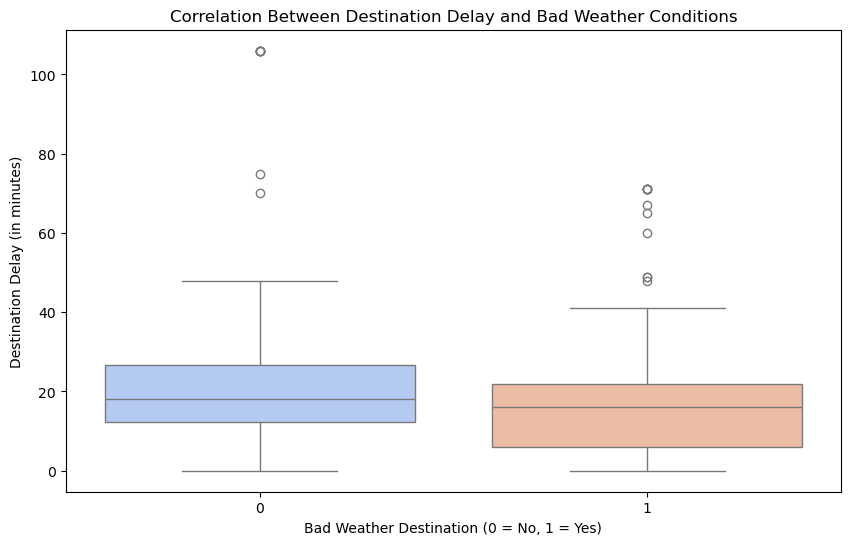

In [81]:
df_destination = df

# Apply the function to the 'WeatherDeparture' column
df_destination['BadWeatherDestination'] = df_destination[['destination_wind', 'destination_visibility', 'departure_sky_condition', 'departure_temperature']].apply(determine_bad_weather_departure, axis=1)

df_destination = df_destination.dropna(subset=['delay_in_minutes', 'BadWeatherDestination'])

# Create a scatter plot to show the correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='BadWeatherDestination', y='delay_in_minutes', data=df_destination, palette='coolwarm')

# Set plot title and labels
plt.title('Correlation Between Destination Delay and Bad Weather Conditions')
plt.xlabel('Bad Weather Destination (0 = No, 1 = Yes)')
plt.ylabel('Destination Delay (in minutes)')

# Show plot
plt.show()

C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_17572\1039127426.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_period_delays.index, y=time_period_delays.values, palette='coolwarm')


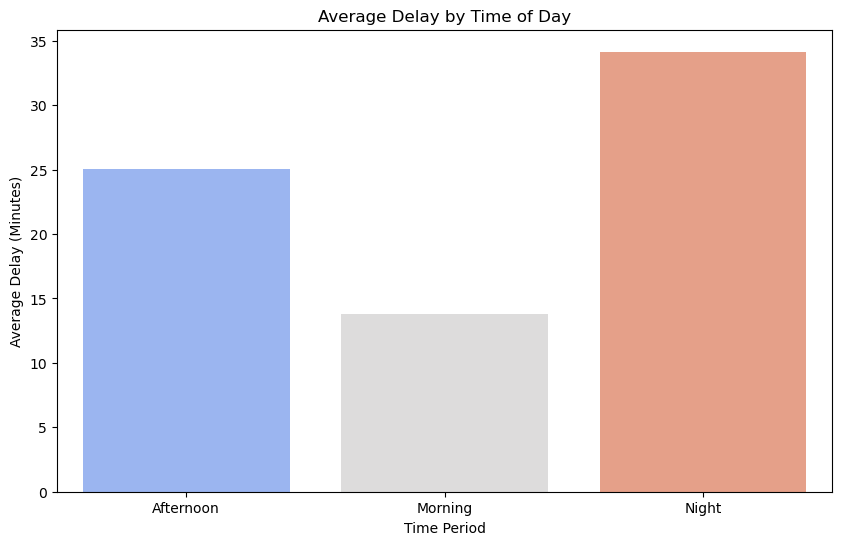

In [82]:
# Analyze by time of the day

# Extract hour from the scheduled_time
df['hour'] = pd.to_datetime(df['scheduled_time']).dt.hour

# Create time periods
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(get_time_period)

# Group by time period and calculate average delay
time_period_delays = df.groupby('time_period')['delay_in_minutes'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=time_period_delays.index, y=time_period_delays.values, palette='coolwarm')
plt.title('Average Delay by Time of Day')
plt.xlabel('Time Period')
plt.ylabel('Average Delay (Minutes)')
plt.show()


In [83]:
# which weather factor has the most impact?

# Create separate columns for each weather condition
df['StrongWindDeparture'] = df['departure_wind'].apply(is_strong_wind)
df['LowVisibilityDeparture'] = df['departure_visibility'].apply(is_low_visibility)
df['BadSkyConditionDeparture'] = df['departure_sky_condition'].apply(is_bad_sky_condition)
df['ExtremeTemperatureDeparture'] = df['departure_temperature'].apply(is_extreme_temperature)

# Calculate average delays for each weather condition
weather_impact = df.groupby(['StrongWindDeparture', 'LowVisibilityDeparture', 'BadSkyConditionDeparture', 'ExtremeTemperatureDeparture'])['delay_in_minutes'].mean()

# Print the result
print(weather_impact)


StrongWindDeparture  LowVisibilityDeparture  BadSkyConditionDeparture  ExtremeTemperatureDeparture
False                False                   False                     False                          30.200000
                                             True                      False                          40.500000
True                 False                   False                     False                          15.470588
                                             True                      False                          15.166667
Name: delay_in_minutes, dtype: float64


In [84]:
# Compare Short Delays vs. Long Delays (Threshold Analysis)

# Create a new column for delay categories
def categorize_delay(delay):
    if delay <= 15:
        return 'Short Delay'
    elif 15 < delay <= 30:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

df['delay_category'] = df['delay_in_minutes'].apply(categorize_delay)

# Group by delay category and calculate average weather conditions
delay_weather = df.groupby('delay_category')[['StrongWindDeparture', 'LowVisibilityDeparture', 'BadSkyConditionDeparture', 'ExtremeTemperatureDeparture']].mean()

# Print the result
print(delay_weather)



                StrongWindDeparture  LowVisibilityDeparture  \
delay_category                                                
Long Delay                 0.354839                     0.0   
Moderate Delay             0.608696                     0.0   
Short Delay                0.716216                     0.0   

                BadSkyConditionDeparture  ExtremeTemperatureDeparture  
delay_category                                                         
Long Delay                      0.322581                          0.0  
Moderate Delay                  0.260870                          0.0  
Short Delay                     0.216216                          0.0  


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_17572\595300902.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=both_ends_delay.index, y=both_ends_delay.values, palette='coolwarm')


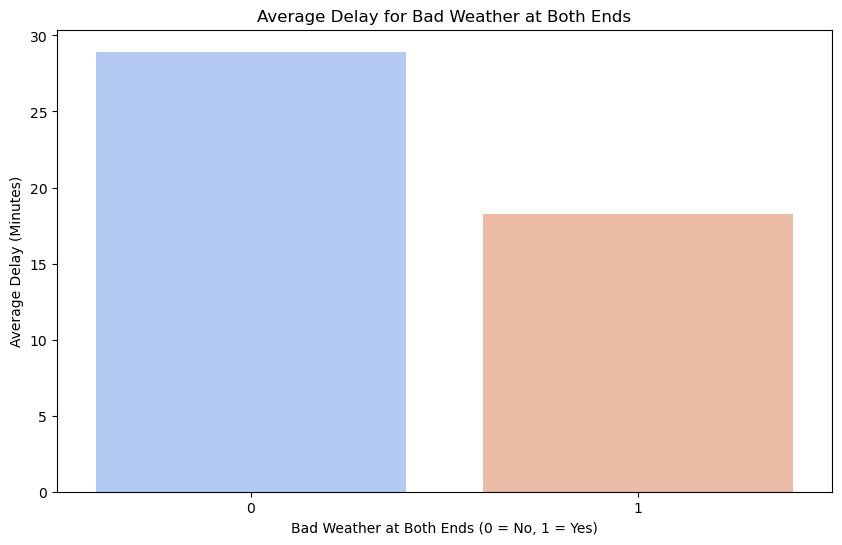

In [85]:
# Check the Correlation Between Departure and Destination Weather

# Create a new column for bad weather at both ends
df['BadWeatherBothEnds'] = (df['BadWeatherDeparture'] & df['BadWeatherDestination']).astype(int)

# Group by BadWeatherBothEnds and calculate average delay
both_ends_delay = df.groupby('BadWeatherBothEnds')['delay_in_minutes'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=both_ends_delay.index, y=both_ends_delay.values, palette='coolwarm')
plt.title('Average Delay for Bad Weather at Both Ends')
plt.xlabel('Bad Weather at Both Ends (0 = No, 1 = Yes)')
plt.ylabel('Average Delay (Minutes)')
plt.show()


In [89]:
# Create separate columns for each weather condition at the destination
df['StrongWindDestination'] = df['destination_wind'].apply(is_strong_wind)
df['LowVisibilityDestination'] = df['destination_visibility'].apply(is_low_visibility)
df['BadSkyConditionDestination'] = df['destination_sky_condition'].apply(is_bad_sky_condition)
df['ExtremeTemperatureDestination'] = df['destination_temperature'].apply(is_extreme_temperature)


In [91]:
# Count how often each extreme weather condition is true for both departure and destination
weather_counts = df[['StrongWindDeparture', 'LowVisibilityDeparture', 'BadSkyConditionDeparture', 'ExtremeTemperatureDeparture', 'StrongWindDestination', 'LowVisibilityDestination', 'BadSkyConditionDestination', 'ExtremeTemperatureDestination']].sum()

# Display the counts
print(weather_counts)


StrongWindDeparture              92
LowVisibilityDeparture            0
BadSkyConditionDeparture         38
ExtremeTemperatureDeparture       0
StrongWindDestination            91
LowVisibilityDestination          0
BadSkyConditionDestination       41
ExtremeTemperatureDestination     0
dtype: int64


In [87]:
df.head()

,id,scheduled_time,departure_icao,arrival_icao,delay_in_minutes,flight_status,airline,flight_number,departure_wind,departure_visibility,departure_sky_condition,departure_temperature,departure_altimeter,destination_wind,destination_visibility,destination_sky_condition,destination_temperature,destination_altimeter,BadWeatherDeparture,BadWeatherDestination,hour,time_period,StrongWindDeparture,LowVisibilityDeparture,BadSkyConditionDeparture,ExtremeTemperatureDeparture,delay_category,BadWeatherBothEnds
0,76,2025-01-08T06:00:00.000,kmco,kfll,17,active,spirit airlines,195,34010KT,10SM,CLR,07/00,3025.0,31008KT,10SM,FEW030,12/07,3016.0,1,1,6,Morning,True,False,False,False,Moderate Delay,1
1,78,2025-01-08T09:35:00.000,kmco,kfll,0,active,azul,6953,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0,1,1,9,Morning,True,False,False,False,Short Delay,1
2,80,2025-01-08T09:35:00.000,kmco,kfll,0,active,jetblue airways,5453,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0,1,1,9,Morning,True,False,False,False,Short Delay,1
3,82,2025-01-08T09:35:00.000,kmco,kfll,0,active,copa airlines,5053,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0,1,1,9,Morning,True,False,False,False,Short Delay,1
4,84,2025-01-08T09:35:00.000,kmco,kfll,0,active,united airlines,3053,35010KT,10SM,CLR,06/01,3023.0,32006KT,10SM,CLR,09/07,3015.0,1,1,9,Morning,True,False,False,False,Short Delay,1
